In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import numpy as np
import pandas as pd
import warnings
from matplotlib import pyplot as plt
from matplotlib.cm import rainbow
import collections
from tqdm import tqdm_notebook as tqdm
import scipy.stats as sps
import pickle

import tensorflow as tf
import tensorflow_probability as tfp
from IPython.display import clear_output

%matplotlib inline

np.seterr(all='raise')
tfd = tfp.distributions


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [2]:
from datasets import *

In [3]:
data_set_small = load_data_set('./datasets/100.10')
data_set_big = load_data_set('./datasets/100.100')

In [4]:
%%writefile basic_solutions.py

import numpy as np
from scipy.optimize import minimize
import scipy.stats as sps

def cut01(ans):
    ans[ans <= 1e-4] = 1e-4
    ans[ans >= 1 - 1e-4] = 1 - 1e-4
    return ans

def bayesian_solve(alpha0, beta0, train, L):
    ans = (train + alpha0 - 1) / (L + alpha0 + beta0 - 2)
    return cut01(ans)

def calc_loglike(p_pred, val, L):
    return (val * np.log(p_pred)).sum() + ((L - val) * np.log(1 - p_pred)).sum()

def calc_bayesian_solve_loglike(alpha0, beta0, train, val, L):
    p_pred = bayesian_solve(alpha0, beta0, train, L)
    return calc_loglike(p_pred, val, L)

def stupid_solution(train, val, L):
    return (train + val + 1e-4) / 2 / (L + 2e-4)

def calc_llp(p_pred, train, test, L):
    p_const = train.sum() / L / train.shape[0]
    if p_const < 1e-4:
        p_const = 1e-4
    return (calc_loglike(p_pred, test, 1e6) - calc_loglike(p_const, test, 1e6)) / 1e6 / test.shape[0]

def evaluate(solution_fun, train, val, test, L):
    p_pred = solution_fun(train, val, L)
    if np.any(p_pred == 0):
        raise Exception("Zero predicted probability")
    return calc_llp(p_pred, train + val, test, 2 * L)

def max_loglike_solution(train, val, L):
    loglike = lambda x: calc_bayesian_solve_loglike(x[0], x[1], train, val, L)
    try:
        res = minimize(fun=lambda x: -loglike(1 + np.exp(x)), x0=(1, 1))
    except FloatingPointError as e:
        return mean_value_solution(train, val, L)
    if not res.success:
        return mean_value_solution(train, val, L)
    else:
        return bayesian_solve(1 + np.exp(res.x[0]), 1 + np.exp(res.x[1]), train + val, L * 2)
    
def mean_value_solution(train, val, L):
    m = ((train + val) / 2. / L).mean()
    if m < 1e-4:
        m = 1e-4
    sum_ab = 1 / m * 20
    return bayesian_solve(m * sum_ab, (1 - m) * sum_ab, train + val, 2 * L)

def calibration_curve_solution(train, val, L):
    try:
        line = sps.linregress((val) / L, (train) / L, )
    except FloatingPointError as e:
        return mean_value_solution(train, val, L)
    if line.slope == 0:
        return mean_value_solution(train, val, L)
    tg = 1 / line.slope
    sum_ab = tg * L - L + 2
    m = ((train + val) / 2 / L).mean()
    if tg != tg or m * sum_ab < 1 or sum_ab > 1e5:
        return max_loglike_solution(train, val, L)
    
    return bayesian_solve(m * sum_ab, sum_ab * (1 - m), train + val, 2 * L)
    
def mean_std_value_solution(train, val, L):
    m = ((train + val) / 2. / L).mean()
    sq_std = ((train + val) / 2. / L).std() ** 2
    if sq_std == 0:
        return mean_value_solution(train, val, L)
    sum_ab = m * (1 - m) / sq_std
    if m * sum_ab < 1 or sum_ab != sum_ab:
        return mean_value_solution(train, val, L)
    return bayesian_solve(m * sum_ab, sum_ab * (1 - m), train + val, 2 * L)
    
def max_loglike_solution2(train, val, L):
    loglike = lambda x: calc_bayesian_solve_loglike(x[0], x[1], train, val, L)
    try:
        res = minimize(fun=lambda x: -loglike(1 + np.exp(x)), x0=(1, 1))
    except FloatingPointError as e:
        return mean_value_solution(train, val, L)
    if not res.success:
        return mean_value_solution(train, val, L)
    else:
        return bayesian_solve(1 + np.exp(res.x[0]), 1 + np.exp(res.x[1]), train, L)

Overwriting basic_solutions.py


In [5]:
from basic_solutions import *

evaluate(stupid_solution, data_set_small.train_data[0], data_set_small.val_data[0], data_set_small.ideal[0], data_set_small.L)

0.019491222731401213

In [6]:
from tqdm import tqdm_notebook as tqdm

def super_puper_solution(train, val, L):
    m_ = np.linspace(0, 1, 100)
    sum_ab_ = np.linspace(3, 1000, 100)
    log_prob = []
    for m in tqdm(m_):
        for sum_ab in sum_ab_:
            alpha = m * sum_ab
            beta = (1 - m) * sum_ab
            log_prob.append(calc_bayesian_solve_loglike(alpha, beta, train, val, L))
    log_prob = np.array(log_prob) - np.max(log_prob)
    log_prob[log_prob < -30] = -30.
    prior_prob = np.exp(log_prob)
    i = 0
    p_pred = np.zeros_like(train, dtype=np.float32)
    for m in tqdm(m_):
        for sum_ab in sum_ab_:
            alpha = m * sum_ab
            beta = (1 - m) * sum_ab
            p_pred += bayesian_solve(alpha, beta, train + val, L * 2) * prior_prob[i]
            i += 1
    p_pred /= prior_prob.sum()
    return p_pred


def super_puper_solution2(train, val, L):
    size = 10000
    m_ = np.random.uniform(0, 1, size=size)
    sum_ab_ = np.random.uniform(3, 1000, size=size)
    log_prob = []
    for i in (range(size)):
        m = m_[i]
        sum_ab = sum_ab_[i]
        alpha = m * sum_ab
        beta = (1 - m) * sum_ab
        log_prob.append(calc_bayesian_solve_loglike(alpha, beta, train, val, L))

    log_prob = np.array(log_prob) - np.max(log_prob)
    log_prob[log_prob < -30] = -30.
    prior_prob = np.exp(log_prob)
    p_pred = np.zeros_like(train, dtype=np.float32)
    
    for i in (range(size)):
        m = m_[i]
        sum_ab = sum_ab_[i]
        alpha = m * sum_ab
        beta = (1 - m) * sum_ab
        p_pred += bayesian_solve(alpha, beta, train + val, L * 2) * prior_prob[i]
    p_pred /= prior_prob.sum()
    return p_pred

In [7]:
def modified_calibration_curve_solution(train, val, L):
    try:
        points = np.array([val[train == i].mean() for i in train])
        line = sps.linregress((points) / L, (train) / L, )
    except FloatingPointError as e:
        return mean_value_solution(train, val, L)
    if line.slope == 0:
        return mean_value_solution(train, val, L)
    tg = line.slope
    sum_ab = tg * L - L + 2
    m = ((train + val) / 2 / L).mean()
    if tg != tg or m * sum_ab < 1 or sum_ab > 1e5:
        return mean_value_solution(train, val, L)
    
    return bayesian_solve(m * sum_ab, sum_ab * (1 - m), train + val, 2 * L)

In [8]:
def evaluate_compare(solutions, ds, plot=False, labels=[], best=True):
    llps = [[] for _ in solutions]
    print (ds.train_data.shape)
    for t_id in (range(ds.train_data.shape[0])):
        for i, solution in enumerate(solutions):
            score = evaluate(solution, ds.train_data[t_id], ds.val_data[t_id], ds.ideal[t_id], ds.L)
            if score != score or score == float('inf') or score == float('-inf'):
                print (t_id, i)
                raise Exception("unnormal score")
            llps[i].append(score)
    if best:
        llps.append([])
        labels.append("true")
        for t_id in range(ds.train_data.shape[0]):
            train = ds.train_data[t_id] + ds.val_data[t_id]
            p_pred = bayesian_solve(ds.alpha0[t_id], ds.beta0[t_id], train, 2 * ds.L)
            llps[-1].append(calc_llp(p_pred, train, ds.ideal[t_id], 2 * ds.L))


    min_ = 1e9
    max_ = -1e9
    ans = []
    
    good = np.ones(len(llps[0]), dtype=np.bool)
    for solution_scores in llps:
        sc = np.array(solution_scores)
        good &= sc == sc
        good &= sc != np.inf
        good &= sc != float("-inf")
    
    for solution_scores in llps:
        sc = np.array(solution_scores)
        ans.append((sc[good].mean(), good.sum()))
        min_ = min(min_, sc[good].min())
        max_ = max(max_, sc[good].max())

        
    if plot:
        for i, label in enumerate(labels):
            plt.hist(llps[i], bins=20, alpha=0.5, label=label + ", %.5f" % ans[i][0], range=(min_, max_))
        plt.ylabel('количество тестов', fontsize=18)
        plt.xlabel('llp', fontsize=18)
        plt.legend(title='# method, mean_score')
        plt.grid()
        plt.show()
        
    return ans

In [ ]:
L = 70
n = 100

ers = []
for i in tqdm(range(100)):
    ans = evaluate_compare([
            max_loglike_solution,
            calibration_curve_solution,
            mean_std_value_solution,
        ], DataSet(1000, n, L, random_seed=i), False, [
            'max_loglike_on_val', 'calibration_curve', 'mean_std_value',
        ], False)
    ers.append([ans[0][0], ans[1][0], ans[2][0]])

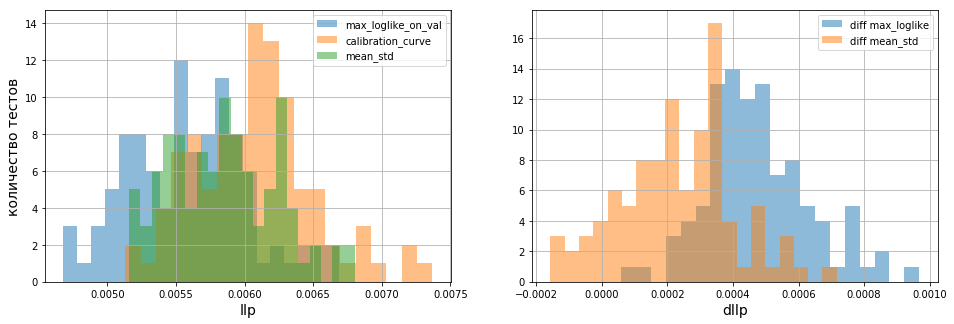

In [11]:
ers = np.array(ers)
plt.figure(figsize=(16, 5))
plt.subplot(1, 2, 1)
plt.hist(ers[:,0], alpha=0.5, label='max_loglike_on_val', bins=20)
plt.hist(ers[:,1], alpha=0.5, label='calibration_curve', bins=20)
plt.hist(ers[:,2], alpha=0.5, label='mean_std', bins=20)
plt.ylabel('количество тестов', fontsize=14)
plt.xlabel("llp", fontsize=14)
plt.legend()
plt.grid()
plt.subplot(1, 2, 2)
plt.hist(ers[:,1] - ers[:,0], label='diff max_loglike', bins=20, alpha=0.5)
plt.hist(ers[:,1] - ers[:,2], label='diff mean_std', bins=20, alpha=0.5)
plt.xlabel("dllp", fontsize=14)
plt.legend()
plt.grid()
plt.show()

10 10
(1000, 10)


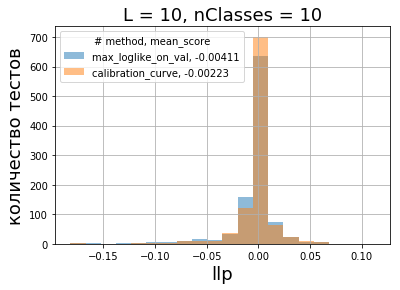

(-0.004105034115579372, 1000)
(-0.0022346274314744004, 1000)
10 20
(1000, 20)


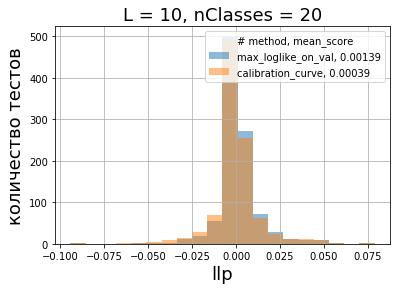

(0.0013918137913698887, 1000)
(0.0003889890165272717, 1000)
10 40
(1000, 40)


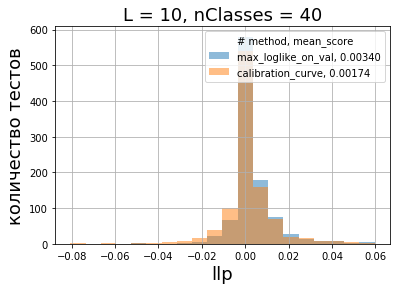

(0.0033986187366022353, 1000)
(0.0017384142930121278, 1000)
10 100
(1000, 100)


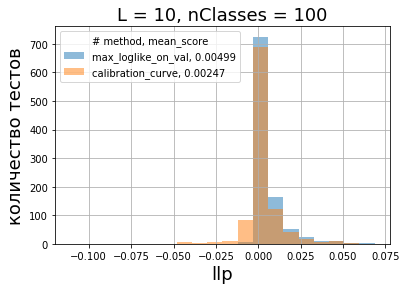

(0.004992002266963556, 1000)
(0.002467431896005735, 1000)
30 10
(1000, 10)


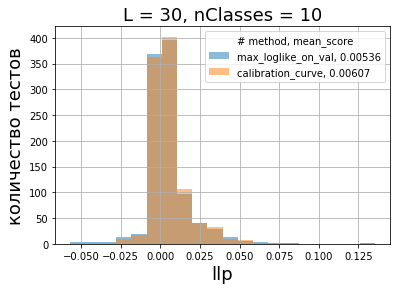

(0.005364513756081173, 1000)
(0.006066297516687847, 1000)
30 20
(1000, 20)


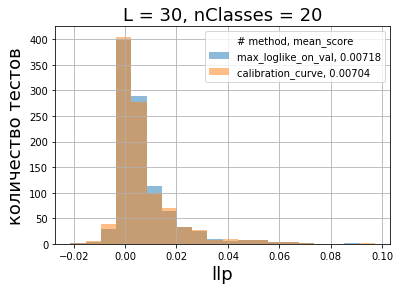

(0.007184179059157545, 1000)
(0.00703594591196509, 1000)
30 40
(1000, 40)


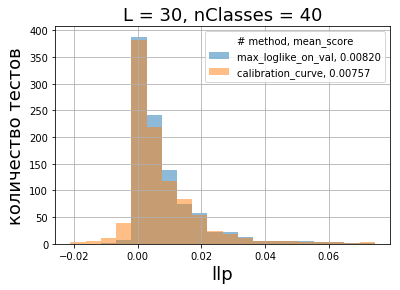

(0.008201145277946114, 1000)
(0.007566362405044682, 1000)
30 100
(1000, 100)


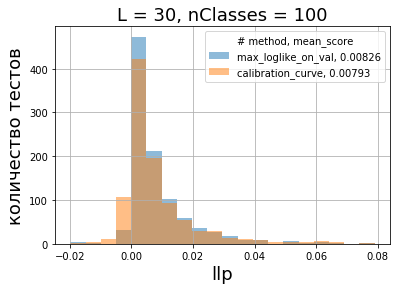

(0.008262705496496204, 1000)
(0.007929370715194216, 1000)
50 10
(1000, 10)


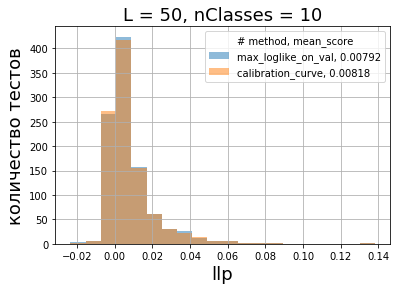

(0.007923167797211523, 1000)
(0.008177600257238673, 1000)
50 20
(1000, 20)


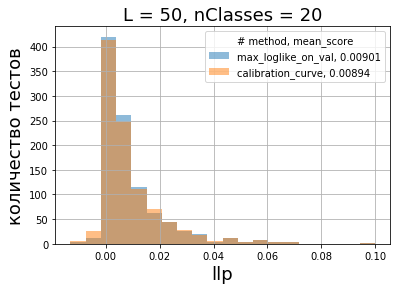

(0.009007081126513147, 1000)
(0.008939392595865733, 1000)
50 40
(1000, 40)


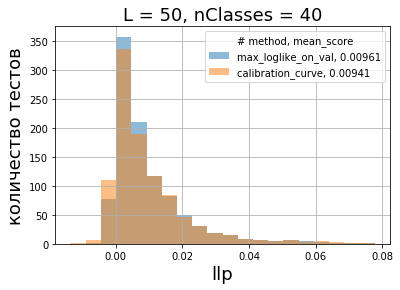

(0.009614659842203771, 1000)
(0.009413769922653517, 1000)
50 100
(1000, 100)


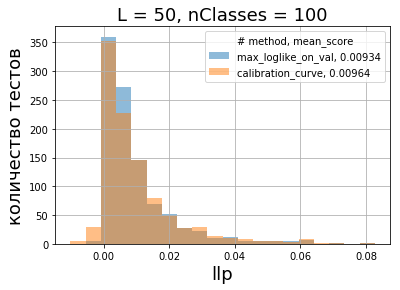

(0.009338338228354347, 1000)
(0.00963862975933696, 1000)
70 10
(1000, 10)


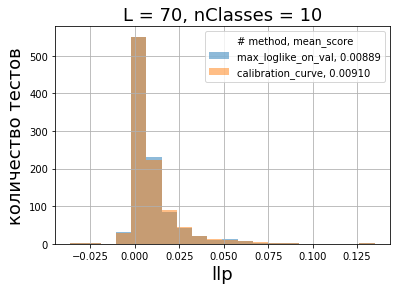

(0.008888520202629344, 1000)
(0.009097832289701409, 1000)
70 20
(1000, 20)


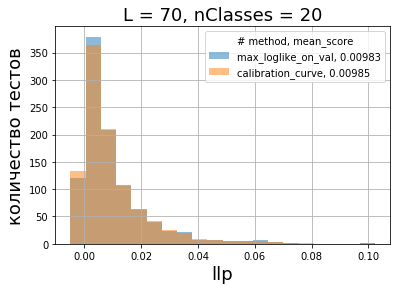

(0.009829597365345898, 1000)
(0.009849688333994265, 1000)
70 40
(1000, 40)


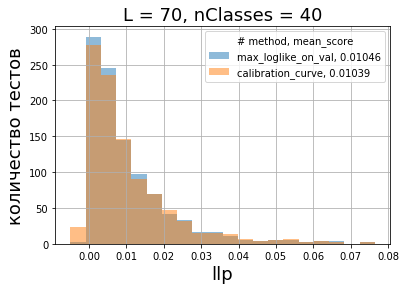

(0.01046073375194932, 1000)
(0.01038556927482009, 1000)
70 100
(1000, 100)


KeyboardInterrupt: 

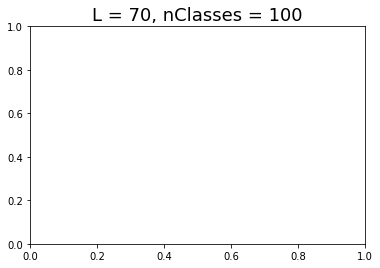

In [120]:
for L in [10, 30, 50, 70, 100, 300, 3000]:
    for n in [10, 20, 40, 100]:
#for L, n in [(30, 30), (100, 200), (3000, 40)]:
        print (L, n)
        plt.figure()
        plt.title("L = %d, nClasses = %d" % (L, n,), fontsize=18)
        ans = evaluate_compare([
                max_loglike_solution,
                calibration_curve_solution,
            ], DataSet(1000, n, L, random_seed=42), True, [
                'max_loglike_on_val', 'calibration_curve'
            ], False)
        for i in range(len(ans)):
            print (ans[i])

In [ ]:
evaluate_compare([
    stupid_solution,
    mean_value_solution,
    max_loglike_solution,
    max_loglike_solution2,
    calibration_curve_solution,
    mean_std_value_solution,
    modified_calibration_curve_solution,
    super_puper_solution2,
], data_set_big, True, [
    'stup', 'm', 'll', 'll2', 'cc', 'ms', 'cc2', 'sp'
])

10
(200, 20)


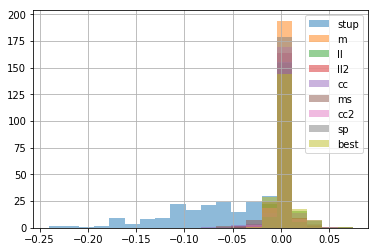

(-0.07134259879559389, 200)
(0.0023051666371548918, 200)
(0.002312080385030529, 200)
(0.0013858080624707203, 200)
(0.0009669388061464622, 200)
(-0.0007030495165458664, 200)
(0.000989248823353239, 200)
(0.002818506039686015, 200)
(0.002920351611521369, 200)
20
(200, 20)


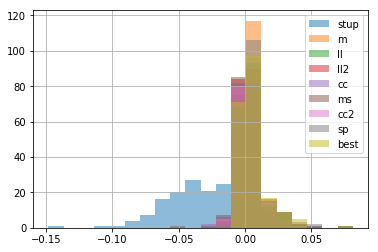

(-0.02487495363110016, 200)
(0.003838261397217172, 200)
(0.005432580657285287, 200)
(0.004237463958860382, 200)
(0.00470362443340854, 200)
(0.0033539663419658882, 200)
(0.0032189514234509113, 200)
(0.005600180853714241, 200)
(0.00566635971636062, 200)
30
(200, 20)


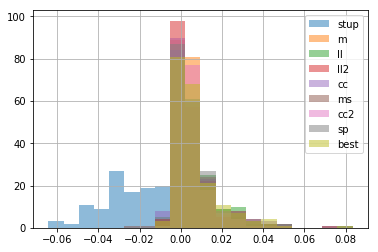

(-0.010325917602610741, 200)
(0.005006246950890605, 200)
(0.00710584166348629, 200)
(0.005859270940490251, 200)
(0.006810343149143278, 200)
(0.005764710341637728, 200)
(0.005037515535799761, 200)
(0.007268712115715433, 200)
(0.0070905784996417994, 200)
50
(200, 20)


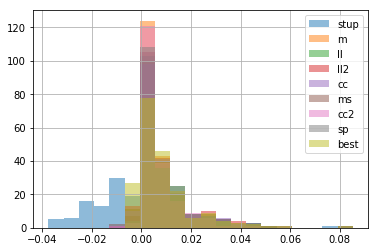

(0.0005095797571555212, 200)
(0.006503448306705073, 200)
(0.008598311229396858, 200)
(0.007413148441485016, 200)
(0.008643750699504143, 200)
(0.008166585178978145, 200)
(0.0065839550371277885, 200)
(0.008779267168073418, 200)
(0.008668532416629826, 200)
70
(200, 20)


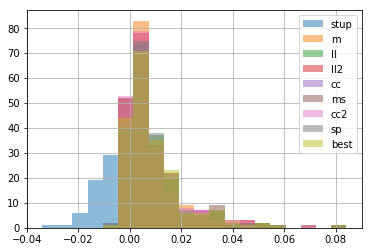

(0.004489997674563513, 200)
(0.007530328717091812, 200)
(0.009240598325317272, 200)
(0.008272953353861998, 200)
(0.009529843268763218, 200)
(0.009061230766535316, 200)
(0.007836401383534626, 200)
(0.009520916681192374, 200)
(0.009530644097716449, 200)
100
(200, 20)


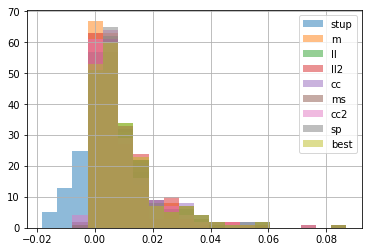

(0.007769870933348715, 200)
(0.00845336448675671, 200)
(0.01024312456982475, 200)
(0.009126549184801073, 200)
(0.010276992253477361, 200)
(0.010027115247363317, 200)
(0.00860564740183186, 200)
(0.010355203680581819, 200)
(0.010316104447971588, 200)
150
(200, 20)


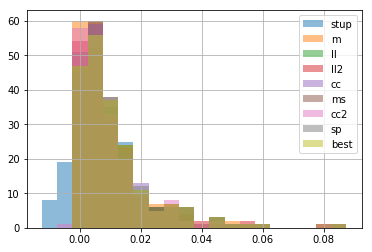

(0.0094155144016779, 200)
(0.009424139396519458, 200)
(0.010810399275851468, 200)
(0.010147814316601753, 200)
(0.01090624640711796, 200)
(0.010714559331414027, 200)
(0.009782644816779606, 200)
(0.01095711836063884, 200)
(0.010860205678131092, 200)
200
(200, 20)


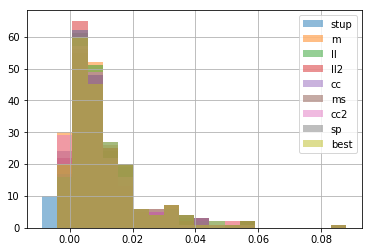

(0.010401730167010221, 200)
(0.010051315166961845, 200)
(0.011012013237980154, 200)
(0.010442192018212042, 200)
(0.011127090772918789, 200)
(0.011075002826766114, 200)
(0.010243241605236241, 200)
(0.011261158623018774, 200)
(0.011204050487968216, 200)
300
(200, 20)


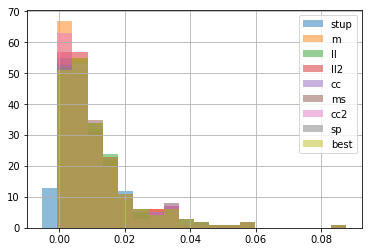

(0.01118318218114811, 200)
(0.010698174445953612, 200)
(0.011332882677644842, 200)
(0.010970524004195611, 200)
(0.011497962549681509, 200)
(0.011496999514299142, 200)
(0.010846319190798582, 200)
(0.011592074979276439, 200)
(0.011588954314647591, 200)
1000
(200, 20)


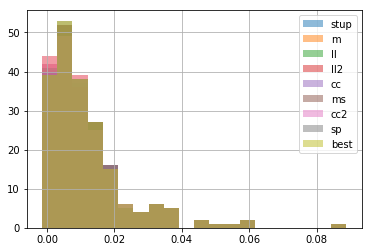

(0.012101615381264062, 200)
(0.01188407957642466, 200)
(0.012029921005947882, 200)
(0.011904849724415573, 200)
(0.012100906428424674, 200)
(0.012113004646837884, 200)
(0.011929949697559788, 200)
(0.012148388417324994, 200)
(0.012154333367974857, 200)
3000
(200, 20)


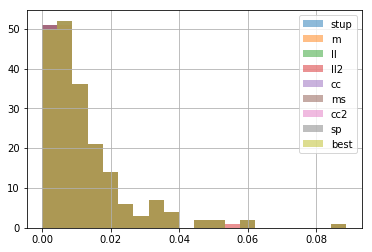

(0.012301026366125456, 200)
(0.012231437191554544, 200)
(0.01226193554582705, 200)
(0.012220109509151072, 200)
(0.0122761418800701, 200)
(0.012288280247593247, 200)
(0.012249177980338003, 200)
(0.01230098087510552, 200)
(0.012304666496039653, 200)


In [68]:
for L in [10, 20, 30, 50, 70, 100, 150, 200, 300, 1000, 3000]:
    print (L)
    ans = evaluate_compare([
            stupid_solution,
            mean_value_solution,
            max_loglike_solution,
            max_loglike_solution2,
            calibration_curve_solution,
            mean_std_value_solution,
            modified_calibration_curve_solution,
            super_puper_solution2,
        ], DataSet(200, 20, L, random_seed=42), True, [
            'stup', 'm', 'll', 'll2', 'cc', 'ms', 'cc2', 'sp'
        ])
    for i in range(len(ans)):
        print (ans[i])